## Crazyflie Simulator - PD Control

States is a 3DOF state vector. Rotations are around the body y-axis, positions and velocities in world coordinates. 

#### boilerplate import code

In [35]:
%config InlineBackend.figure_format='retina' # make plots high resolution

import matplotlib.pyplot as plt
import numpy as np
from numpy import array, sin, cos
# debugging: insert a BK() in your code to pause execution there and get a prompt
# in debugging environment (PDB), you can enter normal python commands and see output, with 
# exception for these single-character commands: (q)uit, (c)ontinue, (s)tep into, (n)ext line, (u)p
# NOTE: if you try to run a different cell while in the debugger you will have to Kernel...Restart 
import pdb; BK = pdb.set_trace

# matlab-like structs for convenient access:
class Bunch(dict): 
    def __init__(self): self.__dict__ = self

#### constants

In [23]:
dt = 1/2000.

p = Bunch() # parameters bunch
p.h = 0.01 # height of body [m]
p.l = 0.06 # length of body [m]
p.J = 1.7e-5 # estimate [kgm^2] http://mikehamer.info/assets/papers/Crazyflie%20Modelling.pdf 
p.m = 30e-3 # mass [kg]
p.g = 9.81 # gravitaional acceleration [ms^-2]
p.b = 6.6e-3 # air drag [Nsm^-1]
p.pos_desired = array((.01, 1)) # [x_world, z_world]

#### Simulation: (full, nonlinear) dynamics and sensor functions
The main dynamics function returns the derivative of the state vector at each time step. 

In [24]:
def R(theta):
    # 2D rotation matrix, vworld = R @ vbody and vbody = R.T @ vworld
    return array((( cos(theta), sin(theta)), 
                  (-sin(theta), cos(theta)))) 
    
def simulate_dynamics(q, u, p):
    thetay = q[0]
    thetadoty = q[1]
    vx, vz = q[3], q[5]
    
    # forces in world frame: [f_x, f_z] 
    f_g = (0, -p.m * p.g) # gravity
    f_z = R(thetay) @ (0, u[0] + p.m * p.g) 
    f_d = -p.b * R(thetay) @ (vx, vz)
    f = f_g + f_z + f_d
    
    # torques around body y-axis: [tau_y]
    tauy = u[1] 

    # calculate derivatives
    thetadotdoty = 1/p.J * (tauy - 0) # in 3D this would be J*thetadotdoty = tau - omega x J omega
    vdot = 1/p.m * f
    qdot = array((thetadoty, thetadotdoty, vx, vdot[0], vz, vdot[1]))
    return qdot

#### Controllers

In [25]:
def attitude_controller(q, p, theta_desired):
    theta = q[0]
    omega = q[1]
    # implement PD controller here
    tau_y = .001*(theta_desired - theta) # fix this 
    return tau_y

def altitude_controller(q, p):
    z = q[4]
    vz = q[5]
    # implement PD controller here
    f_z = 0 # fix this
    return f_z

def lateral_controller(q, p):
    x = q[2]
    vx = q[3]
    # implement PD controller here
    delta_theta = 0 # fix this 
    return delta_theta

#### Simulation
Simulation is a fixed-step numerical integrator. 

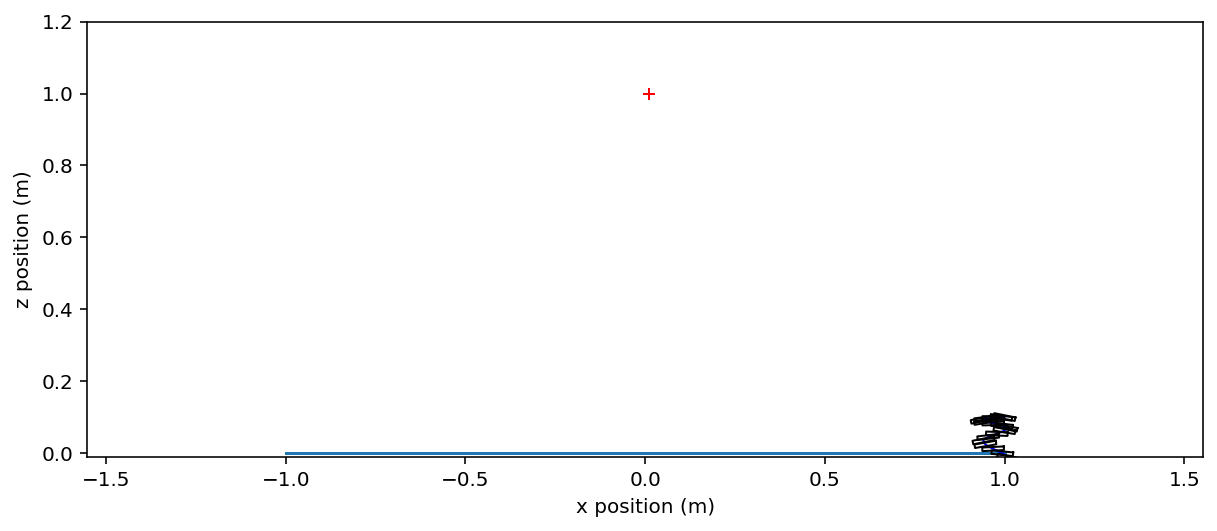

In [30]:
# initialize state and data logs 
q = array([-.2, 0, 1, 0, .1, 0]) # [thetay, omegay, x, vx, z, vz]
u = array([0, 0])
t_final = 5
time = np.arange(0, t_final, dt)
q_data = np.zeros((len(time), len(q)))
u_data = np.zeros((len(time), 2))

# simulate
for idx, t in enumerate(time):
    theta_desired = lateral_controller(q, p)
    tau_y = attitude_controller(q, p, theta_desired)
    f_z_tilde = altitude_controller(q, p)
    u = (f_z_tilde, tau_y)
    q = q + dt * simulate_dynamics(q, u, p)
    u_data[idx,:] = u
    q_data[idx,:] = q

def plotfly(x, z, theta, p, color='k'):
    h = p.l/2; v = p.h/2 
    points = array(((h, h, -h, -h, h), (v, -v, -v, v, v)))
    rotated_points = R(theta) @ points 
    plt.plot(rotated_points[0,:] + x, rotated_points[1,:] + z, color=color, lw=1)
     
plt.figure(figsize=(10,4))        
plt.plot([-1, 1], [0, 0]) # floor
plt.plot(q_data[:,2], q_data[:,4], 'b', lw=1) # trajectory
for q in q_data[::int(0.1/dt),:]: # rectangles
    plotfly(q[2], q[4], q[0], p)
plt.axis('equal')
plt.plot(p.pos_desired[0], p.pos_desired[1], 'r+') # setpoint location
plt.axis([-.5, .5, -.01 , 1.2])
plt.xlabel('x position (m)')
plt.ylabel('z position (m)');

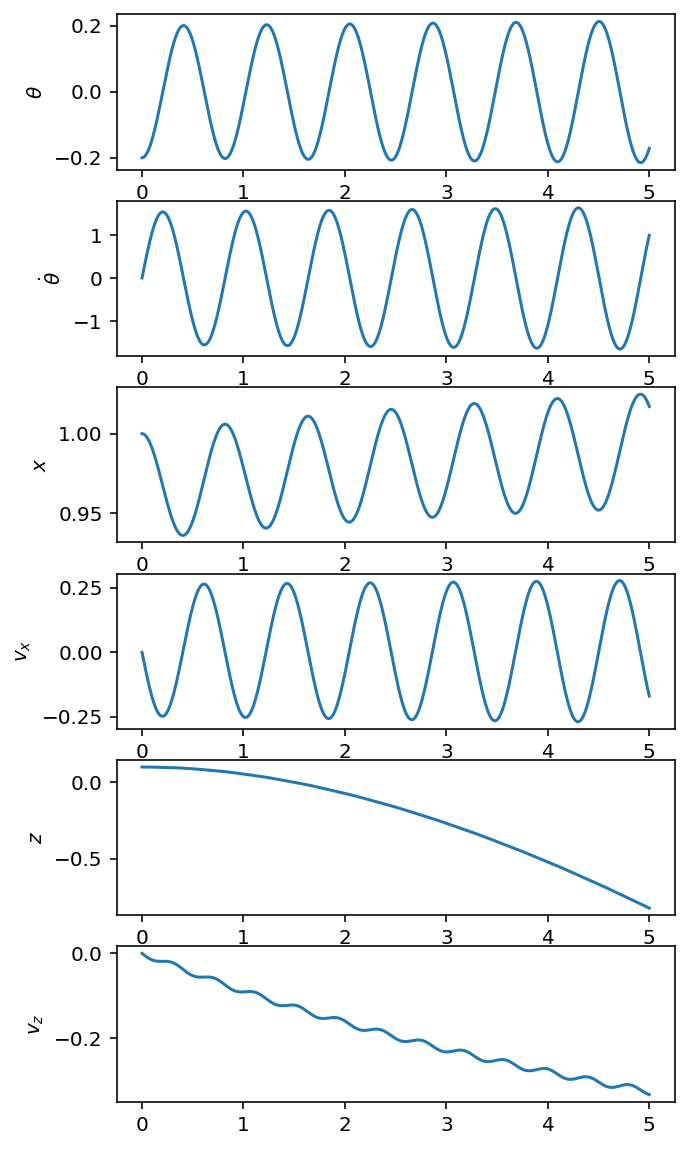

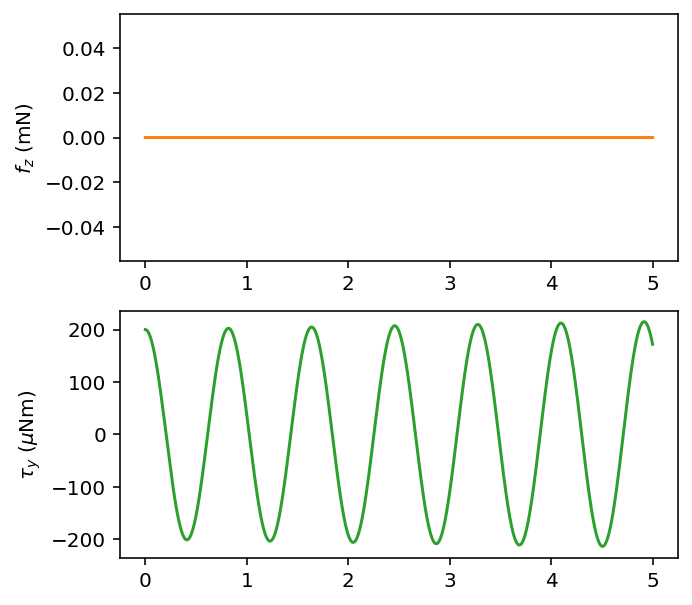

In [31]:
plt.figure(figsize=(5,10))
thetay, thetadoty, x_world, vx_body, z_world, vz_body = q_data.T
ylabels = (r'$\theta$', r'$\dot\theta$', r'$x$', r"$v_x$", r'$z$', r"$v_z$")
for idx in range(6):
    plt.subplot(6,1,idx+1)
    plt.plot(time, q_data[:,idx])
    plt.ylabel(ylabels[idx])

plt.figure(figsize=(5,5))
f_z, tau_y = u_data.T
ylabels = (r'$f_z$ (mN)', r'$\tau_y$ ($\mu$Nm)')
plt.subplot(2,1,1)
plt.plot(time, u_data[:,0]*1e3, 'C1')
plt.ylabel(ylabels[0])
plt.subplot(2,1,2)
plt.plot(time, u_data[:,1]*1e6, 'C2')
plt.ylabel(ylabels[1]);